<a href="https://colab.research.google.com/github/WooHyunKing/Artificial_Intelligence_Study/blob/main/AlexNet_with_PyTorch_201820734.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# code source1: https://www.kaggle.com/code/tiiktak/fashion-mnist-with-alexnet-in-pytorch-92-accuracy/notebook
# code source2: https://pytorch.org/tutorials/
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

In [2]:
# training batches of our network
EPOCHS = 5
# size of each batch
BATCH_SIZE = 512

DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(torch.__version__)
print(DEVICE)

1.11.0+cu113
cuda


In [3]:
from torchvision.transforms import ToTensor
transform=transforms.Compose([transforms.Resize(227),ToTensor()])
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
from torch.utils.data import DataLoader

train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

Sneaker


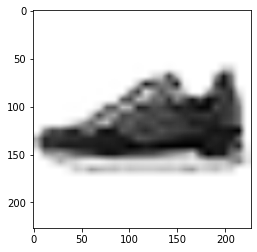

In [5]:
# helper function to show an image
data_index = 2
def matplotlib_imshow(img):
    img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg, cmap="Greys")

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# creat grid of images
img_grid = torchvision.utils.make_grid(images[data_index])

# show images & labels
matplotlib_imshow(img_grid)
print(class_names[labels[data_index]])

### You should implement AlexNet code here! 

In [6]:
class fasion_mnist_alexnet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=96,kernel_size=11,stride=4,padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,stride=2)
    )
    self.conv2=nn.Sequential(
        nn.Conv2d(96,256,5,1,2),
        nn.ReLU(),
        nn.MaxPool2d(3,2)
    )
    self.conv3=nn.Sequential(
        nn.Conv2d(256,384,3,1,1),
        nn.ReLU()
    )
    self.conv4=nn.Sequential(
        nn.Conv2d(384,384,3,1,1),
        nn.ReLU()
    )
    self.conv5=nn.Sequential(
        nn.Conv2d(384,256,3,1,1),
        nn.ReLU(),
        nn.MaxPool2d(3,2)
    )
    
    self.fc1=nn.Linear(256*6*6,4096)
    self.fc2=nn.Linear(4096,4096)
    self.fc3=nn.Linear(4096,10)
    
  def forward(self,x):
      out=self.conv1(x)
      #print(out.shape)
      out=self.conv2(out)
      #print(out.shape)
      out=self.conv3(out)
      #print(out.shape)
      out=self.conv4(out)
      #print(out.shape)
      out=self.conv5(out)
      #print(out.shape)
      out=out.view(out.size(0),-1)
      
      out=F.relu(self.fc1(out))
      #print(out.shape)
      out=F.dropout(out,0.5)
      out=F.relu(self.fc2(out))
      #print(out.shape)
      out=F.dropout(out,0.5)
      out=self.fc3(out)
      #print(out.shape)
      out=F.log_softmax(out,dim=1)

      return out


In [7]:
model = fasion_mnist_alexnet().to(DEVICE)
criterion = F.nll_loss
optimizer = optim.Adam(model.parameters())

In [8]:
def train(model, device, train_loader, optimer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 50 == 0:
            print("Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [9]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)  # 
        print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
        print('='*50)

In [10]:
for epoch in range(1, EPOCHS+1):
    train(model, DEVICE, train_loader, optimizer, epoch)
    test(model, DEVICE, test_loader)

Train Epoch:1 [3136/60000 (5%)]	Loss: 1.032134
Train Epoch:1 [6336/60000 (11%)]	Loss: 1.039963
Train Epoch:1 [9536/60000 (16%)]	Loss: 0.595957
Train Epoch:1 [12736/60000 (21%)]	Loss: 0.552225
Train Epoch:1 [15936/60000 (27%)]	Loss: 0.495514
Train Epoch:1 [19136/60000 (32%)]	Loss: 0.370440
Train Epoch:1 [22336/60000 (37%)]	Loss: 0.434473
Train Epoch:1 [25536/60000 (43%)]	Loss: 0.431470
Train Epoch:1 [28736/60000 (48%)]	Loss: 0.551429
Train Epoch:1 [31936/60000 (53%)]	Loss: 0.420176
Train Epoch:1 [35136/60000 (59%)]	Loss: 0.293325
Train Epoch:1 [38336/60000 (64%)]	Loss: 0.329867
Train Epoch:1 [41536/60000 (69%)]	Loss: 0.343488
Train Epoch:1 [44736/60000 (75%)]	Loss: 0.383021
Train Epoch:1 [47936/60000 (80%)]	Loss: 0.330383
Train Epoch:1 [51136/60000 (85%)]	Loss: 0.423728
Train Epoch:1 [54336/60000 (91%)]	Loss: 0.404870
Train Epoch:1 [57536/60000 (96%)]	Loss: 0.417106

Test set: Average loss: 0.3762, Accuracy: 8631/10000 (86%)

Train Epoch:2 [3136/60000 (5%)]	Loss: 0.476258
Train Epoch:2 

### Questions for today's lecture summary

## Q1. Implement AlexNet code and check out the final result. Submit the screenshot of final accuracy.

## Q2. Check out the output shape of conv1, conv2, conv3, conv4, conv5, fc1, fc2, and fc3 layers. You should submit their 4-dimensional output shapes. For example, Conv1 output = 32x128x56x56, Conv5 output = 32x128x1x1(=32x128).   